# <a id="0"> Table of Contents
6. [Importing Libraries](#6)     
1. [Importing Datasets & Directories](#7) 
1. [Modeling](#8)
    1. [Universal Settings - Image Pre-processing & Augmentation](#8.1)
        1. [](#6)     
        1. [](#8)     
</a>

# <a id="6"> <font color = "lightseagreen">6. Importing Libraries<font></a>

In [104]:
# Basic Libraries
import pandas as pd
import numpy as np

# Path and Data Management
import os
import shutil
import re

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Manipulation/Processing
from PIL import Image
from IPython.display import Image as ipimage

# Pseudo-randomizers
import random
from random import sample

# CNNs, Classification, Dataset Access, Image Augmentation
import tensorflow as tf
from tensorflow import keras # deep learning and neural networks
from tensorflow.keras import layers # layers for neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import xgboost as xgb
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Settings
import warnings
import time

# Notifications
import winsound

In [ ]:
# Session parameters
warnings.filterwarnings("ignore")

# Function to be notified when cell is done executing
def cell_done():
    freq = 500
    dur = 50
    for i in range(0, 10):   
        winsound.Beep(freq, dur)   
        freq-= 20
        dur+= 50

# <a id=7><font color = "lightseagreen">7. Importing Dataframes & Directories<font></a>

In [82]:
def fix_valid_test_dirs(validation_dir_list, test_dir):
    # fixing validation directories
    for val_dir in validation_dir_list:
        os.makedirs(val_dir, exist_ok=True)
    # fixing test directory
    os.makedirs(test_dir, exist_ok=True)

In [83]:
# Loading all dirs and dfs related to the dataset
# Paths for imbalanced dataset
data_path = os.path.join(os.getcwd(), "data")
cloudy_train = os.path.join(data_path, "train/cloudy")
desert_train = os.path.join(data_path, "train/desert")
forest_train = os.path.join(data_path, "train/green_area")
water_train = os.path.join(data_path, "train/water")
cloudy_valid = os.path.join(data_path, "valid/cloudy")
desert_valid = os.path.join(data_path, "valid/desert")
forest_valid = os.path.join(data_path, "valid/green_area")
water_valid = os.path.join(data_path, "valid/water")
imbalanced_test_dir = os.path.join(data_path, "test/test")  # prefix imbalanced will make sense later along the script
fix_valid_test_dirs([cloudy_valid, desert_valid, forest_valid, water_valid], imbalanced_test_dir)

# Paths for balanced dataset
data_balance = os.path.join(os.getcwd(), "data_balance")
cloudy_btrain = os.path.join(data_balance, "train/cloudy")
desert_btrain = os.path.join(data_balance, "train/desert")
forest_btrain = os.path.join(data_balance, "train/green_area")
water_btrain = os.path.join(data_balance, "train/water")
cloudy_bvalid = os.path.join(data_balance, "valid/cloudy")
desert_bvalid = os.path.join(data_balance, "valid/desert")
forest_bvalid = os.path.join(data_balance, "valid/green_area")
water_bvalid = os.path.join(data_balance, "valid/water")
balanced_test_dir = os.path.join(data_balance, "test/test")
fix_valid_test_dirs([cloudy_bvalid, desert_bvalid, forest_bvalid, water_bvalid], balanced_test_dir)

# Dfs of imbalanced set
image_df = pd.read_csv("data/image_df.csv")
imbalanced_train = pd.read_csv("data/imbalanced_train.csv")
imbalanced_valid = pd.read_csv("data/imbalanced_valid.csv")
imbalanced_test = pd.read_csv("data/imbalanced_test.csv")

# Dfs of balanced set
balanced_df = pd.read_csv("data_balance/balanced_df.csv")
balanced_train = pd.read_csv("data_balance/balanced_train.csv")
balanced_valid = pd.read_csv("data_balance/balanced_valid.csv")
balanced_test = pd.read_csv("data_balance/balanced_test.csv")

# <a id = 8><font color="lightseagreen">8. Modeling<font></a>

In [84]:
# FROM ISI'S SCRIPT
# Function to set keras CNN model structure
def make_model(input_shape): 
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (1, 1), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(4, activation='softmax')(x)  # 4 categories --> 4 dense need to find out how these things work exactly
                                                  # FROM ISIS'S CYTOLOGY INDEX: softmax ---> no clue why

    return keras.Model(inputs, x)

## <a id = 8.1><font color="lightseagreen">8.1 Universal Settings - Image Pre-processing & Augmentation<font></a>

In [85]:
# Comparison in the accuracy scores and loss of models run with 64x64, 128x128 and 256x256 res showed that 256x256 had better overall scores
img_height = 256 
img_width = 256
image_size = (img_height, img_width)

# Image augmentation to increase numbers of images on the fly by applying rescaling,
# distortion etc. as the model runs and train the model on multiple potential versions of an image
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Important for normalization of input and avoiding larger images having greater weights
    brightness_range=[.6, 1.3],  # Value randomly selected from range between values of list, which were arbitrarily selected
    channel_shift_range=0.2,  # Channel shift is used to introduce the color augmentation in the dataset so as to make the model learn color based features irrespective of its saturation value.https://stackoverflow.com/questions/70515757/difference-between-channel-shift-range-and-brightness-range-in-imagedatagenerato 
    zoom_range=0.4,
)

In [91]:
# Function to augment image subsets, set up, compile and run model
# Epochs were set to a standard 35
def run_keras(train_dir, val_dir, callbacks_in_dir, batch_size, learning_rate=0.001):  # callbacks_in_dir should be a path in the format "data/epochs/save_at_{epoch}.keras"

    # loading data
    train_ds = datagen.flow_from_directory(
            train_dir_bal,
            seed=400,
            target_size=image_size,
            batch_size=batch_size,
            class_mode="categorical"
    )
    val_ds = datagen.flow_from_directory(
            val_dir_bal,
            seed=400,
            target_size=image_size,
            batch_size=batch_size,
            class_mode="categorical"
    )
    
    # setting up model
    model = make_model(input_shape=image_size + (3,))
        
    # compiling
    model.compile(
            optimizer=keras.optimizers.Adamax(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
    )
        
    # Where should the callbacks (aka saved instances of the model per epoch) be saved 
    callbacks = [keras.callbacks.ModelCheckpoint(callbacks_in_dir)]
        
    # defining step sizes that will allow the model to run through all data points over each epoch
    step_size_train = train_ds.n//train_ds.batch_size
    step_size_val = val_ds.n//val_ds.batch_size
        
    # creating points of reference to keep track of sections in cell output
    print("\n", f"Epochs/scores for batch_size = {batch_size}")
        
    # running model
    #try:
    hist = model.fit(
            train_ds, 
            epochs=2,
            steps_per_epoch = step_size_train,
            validation_data=val_ds,
            validation_steps = step_size_val,
            callbacks = callbacks
    )
    #except:
        #print(f"Could not execute for batch_size = {batch_size}")
    #else:
    print(f"Finished for batch_size = {batch_size}")
            
    # saving scores history in .csv for easy access and visualisations potentially in later sessions
    balanced_hist_df = pd.DataFrame(hist.history)
    balanced_hist_df.to_csv(f"batch{batch_size}_lr{learning_rate}.csv", index = 0)
    
    # deleting session so keras doesn't just keep building up on knowledge already aquired
    keras.backend.clear_session()
    
    # to let the pc cool down a bit between each cycle in case the function is called in a loop
    time.sleep(120) 

## <a id = 8.2><font color="lightseagreen">8.2 Baseline Models<font></a>

### <a id = 8.2.1><font color="lightseagreen">8.2.1 CNN- Keras<font></a>

<h3 style = "color:lightseagreen">- Imbalanced Set</h3>

In [92]:
train_dir_imb = os.path.join(os.getcwd(), "data/train")
val_dir_imb = os.path.join(os.getcwd(), "data/valid")

In [36]:
# picking a minibatch of relatively medium proportions to start with for the comparison between imbalanced and balanced data
batch_size = 128 # https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [37]:
# From Isi's adapted
# Loading training data
train_ds_imb = datagen.flow_from_directory(
    train_dir_imb,
    seed=400,  # just has to stay the same, equivalent of random_state
    target_size=image_size,
    batch_size=batch_size,  # how many images per step
    class_mode="categorical"  # for multi-class
)

# Loading validation data
val_ds_imb = datagen.flow_from_directory(
    val_dir_imb,
    seed=400,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

Found 4474 images belonging to 4 classes.
Found 559 images belonging to 4 classes.


In [60]:
# Defining model. No changes will be applied on parameters set in this section
model = make_model(input_shape=image_size + (3,)) # Image size + 3 channels of colors

In [61]:
# From Isi adapted
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [40]:
# Defining step sizes as exact divisors of the train and test set respectively. This way the model will run through the entire set each epoch.
# Test set should all be processed in one batch
step_size_train = train_ds_imb.n//train_ds_imb.batch_size
step_size_val = val_ds_imb.n//val_ds_imb.batch_size

In [41]:
# TRAINING MODEL - 256x256 --> gave best results. keeping it
callbacks = [
    keras.callbacks.ModelCheckpoint("data/epochs_imbalanced_data/save_at_{epoch}.keras"),
]

hist = model.fit(
    train_ds_imb, 
    epochs=50,
    steps_per_epoch = step_size_train,
    validation_data=val_ds_imb,
    validation_steps = step_size_val,
    callbacks = callbacks,
)

#cell_done()

Epoch 1/50
34/34 [==============================] - 170s 5s/step - loss: 0.8408 - accuracy: 0.5759 - val_loss: 0.6457 - val_accuracy: 0.6309
Epoch 2/50
34/34 [==============================] - 176s 5s/step - loss: 0.4699 - accuracy: 0.7835 - val_loss: 0.3963 - val_accuracy: 0.8145
Epoch 3/50
34/34 [==============================] - 167s 5s/step - loss: 0.3642 - accuracy: 0.8495 - val_loss: 0.3422 - val_accuracy: 0.8691
Epoch 4/50
34/34 [==============================] - 168s 5s/step - loss: 0.3399 - accuracy: 0.8599 - val_loss: 0.3328 - val_accuracy: 0.8496
Epoch 5/50
34/34 [==============================] - 168s 5s/step - loss: 0.3446 - accuracy: 0.8622 - val_loss: 0.4250 - val_accuracy: 0.7891
Epoch 6/50
34/34 [==============================] - 166s 5s/step - loss: 0.3364 - accuracy: 0.8578 - val_loss: 0.3138 - val_accuracy: 0.8711
Epoch 7/50
34/34 [==============================] - 167s 5s/step - loss: 0.3121 - accuracy: 0.8741 - val_loss: 0.3105 - val_accuracy: 0.8691
Epoch 8/50
34

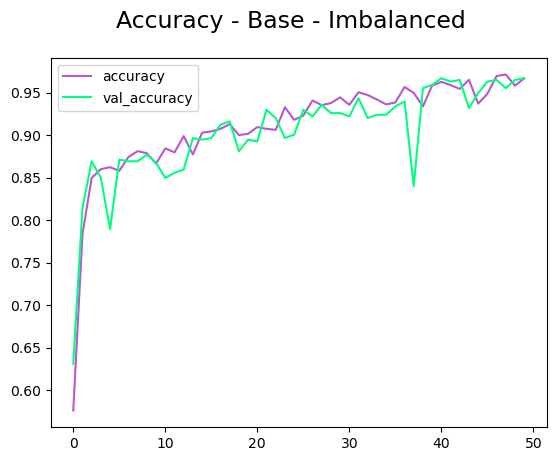

In [42]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="mediumorchid", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="springgreen", label="val_accuracy")
fig.suptitle("Accuracy - Base - Imbalanced", fontsize=17)
plt.legend(loc="upper left")
plt.show()

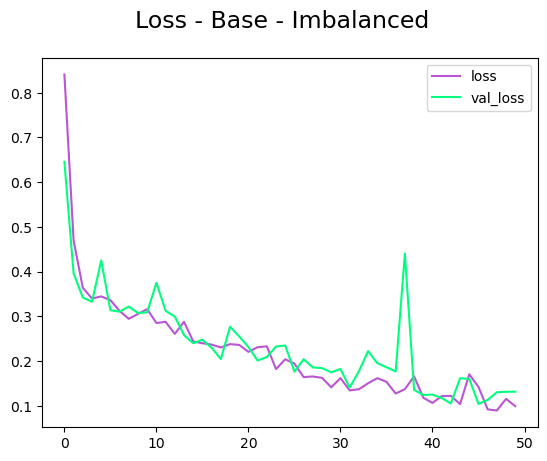

In [43]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="mediumorchid", label="loss")
plt.plot(hist.history["val_loss"], color="springgreen", label="val_loss")
fig.suptitle("Loss - Base - Imbalanced", fontsize=17)
plt.legend(loc="upper right")
plt.show()

In [95]:
# Epoch 43 has provided the best relative scores
checkpoint_path_base_imb = os.path.join(data_path, "epochs_imbalanced_data", "save_at_43.keras")
model.load_weights(checkpoint_path_base_imb)

5/5 [==============================] - 10s 2s/step


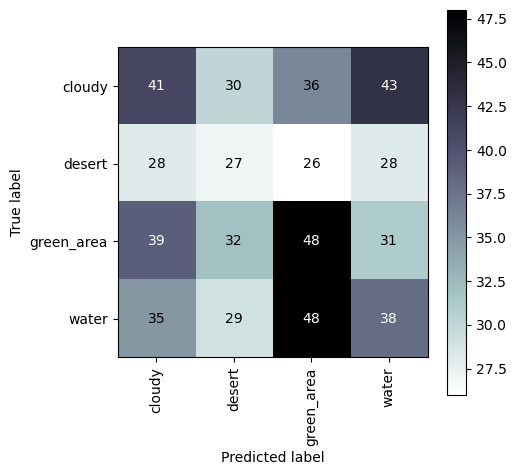

              precision    recall  f1-score     support
cloudy         0.286713  0.273333  0.279863  150.000000
desert         0.228814  0.247706  0.237885  109.000000
green_area     0.303797  0.320000  0.311688  150.000000
water          0.271429  0.253333  0.262069  150.000000
accuracy       0.275492  0.275492  0.275492    0.275492
macro avg      0.272688  0.273593  0.272877  559.000000
weighted avg   0.275906  0.275492  0.275443  559.000000


In [96]:
# CONFUSION MATRIX AND CLASSIFICATION REPORT
# true labels
true_labels = val_ds_imb.classes

# predictions
pred_imb = model.predict(val_ds_imb)
pred_labels = np.argmax(pred_imb, axis=-1)

# compute the confusion matrix
cm_imb = confusion_matrix(true_labels, pred_labels)

# class names
class_names = list(val_ds_imb.class_indices.keys())

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Increase the size of the figure
cm_viz = ConfusionMatrixDisplay(confusion_matrix=cm_imb, display_labels=class_names)
cm_viz.plot(ax=ax, cmap='bone_r', xticks_rotation='vertical')   # cmap I like but not for here: "bone_r"
plt.show()

sns.set(font_scale=1.5)
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# report as a dataframe
print(df_report)

<h3 style = "color:lightseagreen">- Imbalanced Set Against Unseen Data (test set)</h3>

Example No 0: 



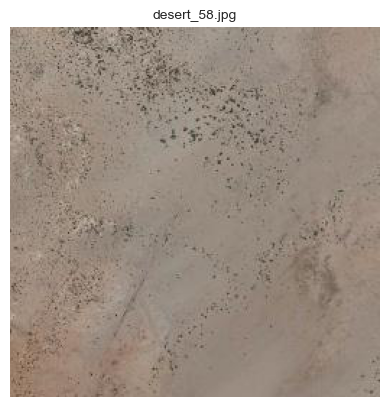

1/1 [==============================] - 0s 31ms/step
The model predicts this image as: desert with 100.00% confidence 

Example No 1: 



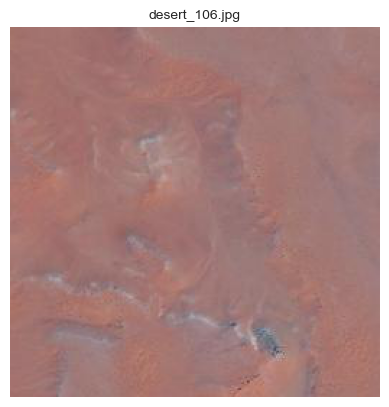

1/1 [==============================] - 0s 31ms/step
The model predicts this image as: desert with 100.00% confidence 

Example No 2: 



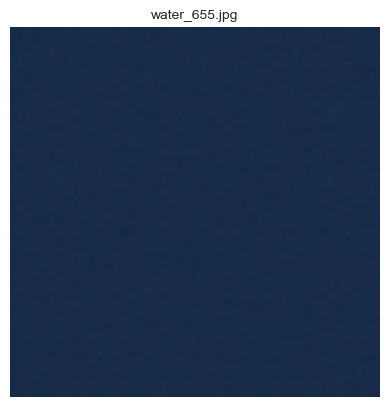

1/1 [==============================] - 0s 31ms/step
The model predicts this image as: water with 100.00% confidence 



In [107]:
# Adapted from Isi's
for i in range(3):
    print(f"Example No {i}:", "\n")
    rand_img_dir = np.random.choice(os.listdir(imbalanced_test_dir))
    img_path = os.path.join(imbalanced_test_dir, rand_img_dir)

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{rand_img_dir}", fontsize = 10)
    plt.show()

    # load and preprocess the image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = np.expand_dims(image.img_to_array(img), axis=0)

    # predictions
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])  # class with highest probability
    class_prob = predictions[0][class_idx]

    # class label and confidence
    class_label = {v: k for k, v in train_ds_imb.class_indices.items()}[class_idx]
    print(f"The model predicts this image as: {class_label} with {class_prob*100:.2f}% confidence", "\n")

### <font color="lightseagreen">- Balanced Set<font>

In [62]:
train_dir_bal = os.path.join(os.getcwd(), "data_balance/train")
val_dir_bal = os.path.join(os.getcwd(), "data_balance/valid")

In [63]:
# run_keras(train_dir_bal, val_dir_bal, [128], data_balance, "bal_base")

In [64]:
batch_size = 128
# From Isi's adapted
# Loading training data
train_bal_ds = datagen.flow_from_directory(
    train_dir_bal,
    seed=400,  # just has to stay the same, equivalent of random_state
    target_size=image_size,
    batch_size=batch_size,  # how many images per step
    class_mode="categorical"  # for multi-class
)

# Loading validation data
val_bal_ds = datagen.flow_from_directory(
    val_dir_bal,
    seed=400,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

Found 3496 images belonging to 4 classes.
Found 436 images belonging to 4 classes.


In [65]:
step_size_btrain = train_bal_ds.n//train_bal_ds.batch_size
step_size_bval = val_bal_ds.n//val_bal_ds.batch_size

In [47]:
time.sleep(180)

In [52]:
keras.backend.clear_session()

In [66]:
# TRAINING MODEL
callbacks = [
    keras.callbacks.ModelCheckpoint("data_balance/epochs_bal_base_rep/save_at_{epoch}.keras")
]

hist = model.fit(
    train_bal_ds, 
    epochs=50,
    steps_per_epoch = step_size_btrain,
    validation_data=val_bal_ds,
    validation_steps = step_size_bval,
    callbacks = callbacks
)

cell_done()

Epoch 1/50
27/27 [==============================] - 134s 5s/step - loss: 0.6777 - accuracy: 0.6502 - val_loss: 0.4624 - val_accuracy: 0.7083
Epoch 2/50
27/27 [==============================] - 131s 5s/step - loss: 0.3971 - accuracy: 0.8254 - val_loss: 0.3371 - val_accuracy: 0.8594
Epoch 3/50
27/27 [==============================] - 131s 5s/step - loss: 0.3617 - accuracy: 0.8465 - val_loss: 0.4094 - val_accuracy: 0.8229
Epoch 4/50
27/27 [==============================] - 133s 5s/step - loss: 0.3413 - accuracy: 0.8550 - val_loss: 0.3366 - val_accuracy: 0.8646
Epoch 5/50
27/27 [==============================] - 130s 5s/step - loss: 0.3261 - accuracy: 0.8670 - val_loss: 0.3119 - val_accuracy: 0.8672
Epoch 6/50
27/27 [==============================] - 130s 5s/step - loss: 0.3235 - accuracy: 0.8726 - val_loss: 0.3022 - val_accuracy: 0.8854
Epoch 7/50
27/27 [==============================] - 130s 5s/step - loss: 0.2967 - accuracy: 0.8821 - val_loss: 0.2886 - val_accuracy: 0.8776
Epoch 8/50
27

In [67]:
cell_done()

In [68]:
# # to fix facecolor that turned gray for some reason https://stackoverflow.com/questions/4581504/how-to-set-opacity-of-background-colour-of-graph-with-matplotlib#:~:text=If%20you%20want%20to%20make,of%20all%20facecolors%20to%200%25.
# plt.rcParams.update({
#     "figure.facecolor":  (1.0, 0.0, 0.0, 0.0),  # red   with alpha = 30%
#     "axes.facecolor":    (0.0, 1.0, 0.0, 0.0),  # green with alpha = 50%
#     "savefig.facecolor": (0.0, 0.0, 1.0, 0.0),  # blue  with alpha = 20%
#     "legend.facecolor": "white"
# })

In [69]:
balanced_hist_df = pd.DataFrame(hist.history)
balanced_hist_df.to_csv("data_balance/base_balanced_scores_ne.csv", index = 0)

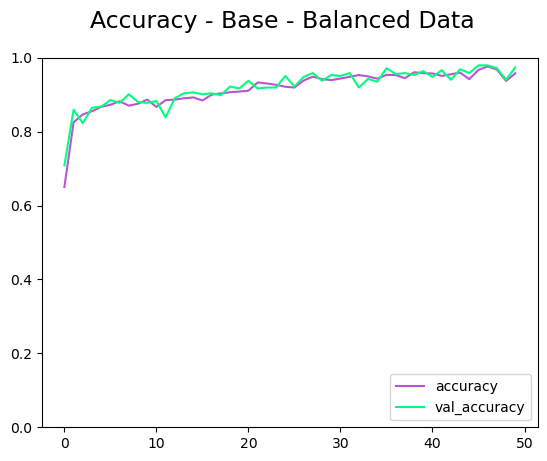

In [73]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="mediumorchid", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="springgreen", label="val_accuracy")
fig.suptitle("Accuracy - Base - Balanced Data", fontsize=17)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()

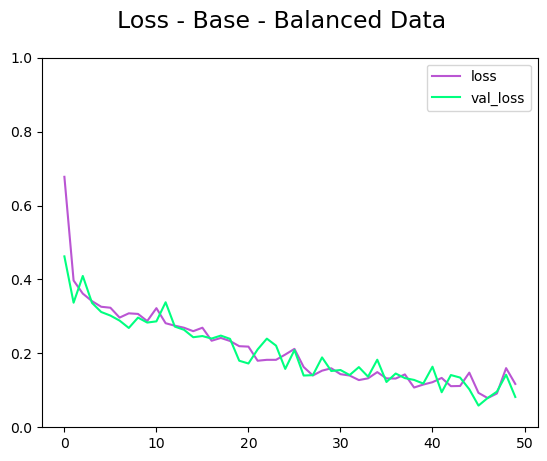

In [71]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="mediumorchid", label="loss")
plt.plot(hist.history["val_loss"], color="springgreen", label="val_loss")
fig.suptitle("Loss - Base - Balanced Data", fontsize=17)
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.show()

In [109]:
# Best Epoch is 47 - Highest accuracy, least difference between loss and val_loss. Accuracy and val_accuracy practically identical
checkpoint_path_base_bal = os.path.join(data_balance, "epochs_bal_base_rep", "save_at_47.keras")
model.load_weights(checkpoint_path_base_bal)

4/4 [==============================] - 7s 2s/step


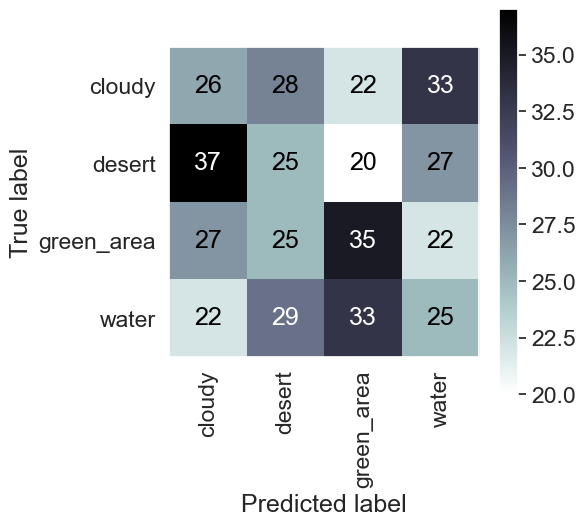

              precision    recall  f1-score     support
cloudy         0.232143  0.238532  0.235294  109.000000
desert         0.233645  0.229358  0.231481  109.000000
green_area     0.318182  0.321101  0.319635  109.000000
water          0.233645  0.229358  0.231481  109.000000
accuracy       0.254587  0.254587  0.254587    0.254587
macro avg      0.254404  0.254587  0.254473  436.000000
weighted avg   0.254404  0.254587  0.254473  436.000000


In [113]:
# CONFUSION MATRIX AND CLASSIFICATION REPORT
# true labels
true_labels = val_bal_ds.classes

# predictions
pred_bal_base = model.predict(val_bal_ds)
pred_labels = np.argmax(pred_bal_base, axis=-1)

# compute the confusion matrix
cm_bal_base = confusion_matrix(true_labels, pred_labels)

# class names
class_names = list(val_bal_ds.class_indices.keys())

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Increase the size of the figure
cm_viz = ConfusionMatrixDisplay(confusion_matrix=cm_bal_base, display_labels=class_names)
cm_viz.plot(ax=ax, cmap='bone_r', xticks_rotation='vertical')
ax.grid(False)
plt.show()

sns.set(font_scale=1.5)
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# report as a dataframe
print(df_report)

Example No 0: 



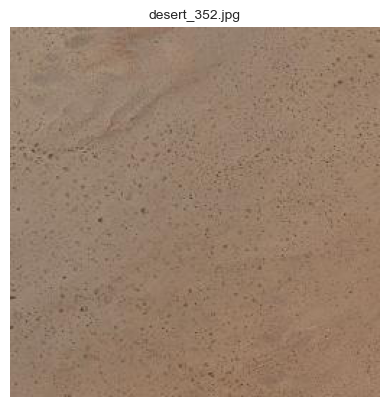

1/1 [==============================] - 0s 30ms/step
The model predicts this image as: desert with 100.00% confidence 

Example No 1: 



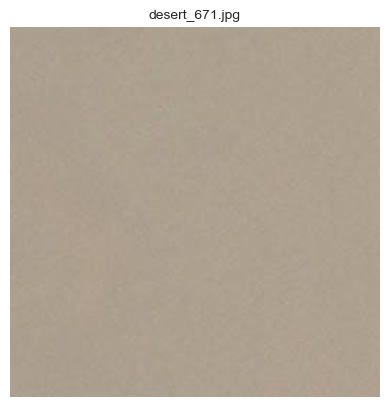

1/1 [==============================] - 0s 31ms/step
The model predicts this image as: desert with 100.00% confidence 

Example No 2: 



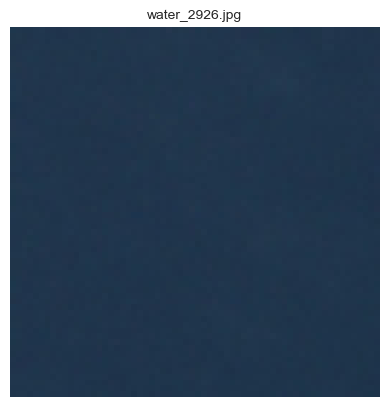

1/1 [==============================] - 0s 30ms/step
The model predicts this image as: water with 100.00% confidence 



In [114]:
# Adapted from Isi's
for i in range(3):
    print(f"Example No {i}:", "\n")
    rand_img_dir = np.random.choice(os.listdir(balanced_test_dir))
    img_path = os.path.join(balanced_test_dir, rand_img_dir)

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{rand_img_dir}", fontsize = 10)
    plt.show()

    # load and preprocess the image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = np.expand_dims(image.img_to_array(img), axis=0)

    # predictions
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])  # class with highest probability
    class_prob = predictions[0][class_idx]

    # class label and confidence
    class_label = {v: k for k, v in train_ds_imb.class_indices.items()}[class_idx]
    print(f"The model predicts this image as: {class_label} with {class_prob*100:.2f}% confidence", "\n")

<h2 style = "color:lightseagreen">5.2.2 XGBoost</h2>

<h3 style = "color:lightseagreen">- Balanced Set</h3>

<h3 style = "color:lightseagreen">- Imbalanced Set</h3>

<h2 style = "color:lightseagreen">5.3 Model Optimization</h2>

<h2 style = "color:lightseagreen">5.3.1 Keras - CNN</h2>

In [ ]:
batch_sizes = [32, 64, 128, 256, 300, 450, len(balanced_train)]
callback_paths = []
epoch = "{epoch}"

for batch_size in batch_sizes:
    callback_paths.append(f"data_balance/epochs_bal_batch_{batch_size}/save_at_{epoch}.keras")

In [ ]:
i = 0

for batch_size in batch_sizes:
    run_keras(train_dir_bal, val_dir_bal, batch_size, callback_paths[i])
    i += 1

<h2 style = "color:lightseagreen">5.3.2 XGBoost</h2>